## Subgradient method for Quadratic problem

Q1. 다음 $x \in \mathbb{R}^n$에 대한 Lagrangian을 구하는 과정을 설명하고 dual problem을 도출하세요. 세션에 나온 것과 동일한 문제입니다. $P$는 positive definite matrix입니다.

$$ {\displaystyle {\begin{aligned}&{\text{minimize }}\frac{1}{2}x^TPx - q^Tx\\[0.5ex]&{\text{subject to }}x_i^2 \leq 1,\,i=1,\,2,\,...,\,n\end{aligned}}} $$

$$ L(x, \lambda) = (1/2)x^T(P + \mathbf{diag}(2\lambda))x - q^Tx - \mathbf{1}^T\lambda $$

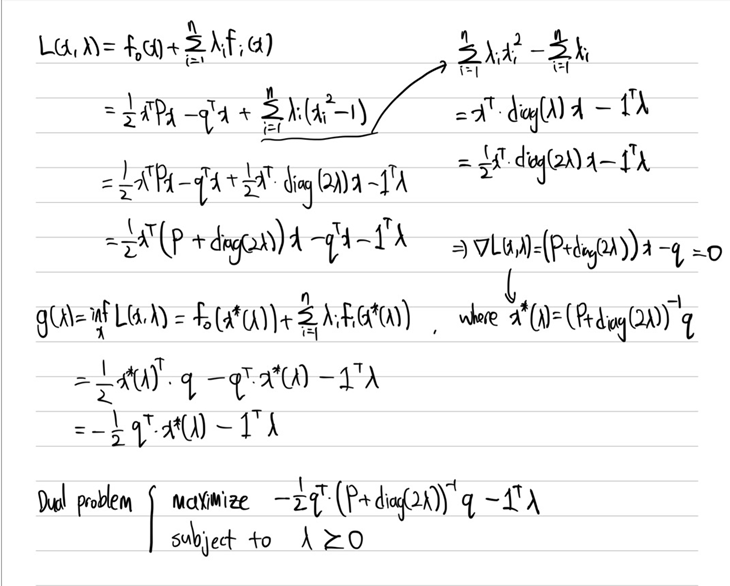

$n = 50$에 대해 문제가 다음과 같이 세팅되었습니다.

In [1]:
using Random
Random.seed!(2023)
n = 50;
A = randn(n,n);
P = (A'* A); # positive definite matrix를 만들기 위해서입니다.
q = randn(n,1);

그리고 Convex 패키지로 문제를 풀면 아래와 같습니다. 이것을 optimal value라고 합시다. 참고로 Convex 패키지는 원래 줄리아의 `.`를 이용한 broadcasting 문법을 지원하지 않으므로, 아래와 같이 패키지 내에서 정의된 operation으로 써 주어야 합니다. 

In [2]:
using Convex, SCS
x = Variable(n)
obj = 0.5*quadform(x, P, assume_psd=true) - q'* x # primal objective function
problem = minimize(obj, [dot(^)(x,2) <= 1]) # 생소한 무언가가 있을 때에는 패키지 홈페이지의 supported operation 탭을 참고하면 됩니다.
solve!(problem, SCS.Optimizer)

------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 103, constraints m: 306
cones: 	  z: primal zero / dual free vars: 1
	  l: linear vars: 101
	  q: soc vars: 204, qsize: 52
settings: eps_abs: 1.0e-004, eps_rel: 1.0e-004, eps_infeas: 1.0e-007
	  alpha: 1.50, scale: 1.00e-001, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-006
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 2756, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0|4.54e+001 2.55e+000 1.32e+002 -7.18e+001 1.00e-001 1.37e-003 
   250|9.06e-003 4.46e-004 7.91e-004 -6.46e+000 1.00e-001 6.06e-

In [3]:
f_min = evaluate(obj)

1-element Vector{Float64}:
 -6.464405592047438

Q2. 이제 primal problem과 dual problem 각각에 대해 subgradient method를 적용해 봅시다. 주어진 코드의 빈칸을 채우세요.

#주의할 점: 다음과 같은 오류가 발생할 수 있습니다. `Cannot 'convert' an object of type Matrix{Float64} to an object of type Float64`  
이 오류는 float자료형과 $1 \times 1$ matrix 자료형을 다르게 취급하기 때문에 나는 오류입니다. `a`가 $1 \times 1$ matrix일 때, `a[1]`은 그 matrix의 원소(float)를 가리킵니다.

 $$ \text{update value of} ~ f_{\text{best}}:~~f^{(k)}_{\text{best}}=\min \{f^{(k-1)}_{\text{best}},f(x^{(k)}) \}$$

$$\text{Polyak's step size}:\alpha_k=\dfrac{f(x^{(k)})-f^\star}{||g^{(k)}||^2_2} $$

 $$ \text{update subgradient}: ~ x^{(k+1)}=x^{(k)}-\alpha_kg^{(k)}$$

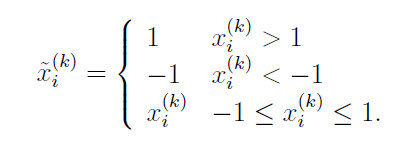

In [4]:
fp = [Inf]; fpbest = [Inf];
print("Starting projected subgradient algorithm for the primal problem...")

# initial point
x = zeros(n,1);

k = 1;
maxiters = 100;

while k < maxiters 

    # subgradient를 계산하세요.
    g = P * x - q

    # primal objective values
    fval = (1/2)*x'*P*x - q'*x;
    push!(fp, fval[1]); push!(fpbest, min(fpbest[end],fval[1]))

    # Polyak's step size에 따라 step size α를 입력하세요. 이때 f*는 위에서 패키지로 구한 값으로 가정합니다.
    alpha = (fval-f_min)/norm(g)^2;

    # subgradient update
    x = x - alpha[1]*g;  k = k + 1;

    # feasible set으로의 projection
    x = max.(min.(x,1),-1); 

end

Starting projected subgradient algorithm for the primal problem...

#강의안에 나온 대로 $\alpha = 0.1$, $x^{(k)}$의 nearby feasible point를 사용해 dual problem에 대한 projected subgradient method를 구현해 보세요.

#주의할 점: `Diagonal()`로 대각행렬을 만들 때, 인풋으로 matrix를 넣으면 $1 \times 1$ matrix만 반환됩니다. 가령 $ n \times 1 $ matrix a를 인풋으로 넣어 n개의 주대각 원소를 갖는 대각행렬을 만들고 싶다면 `Diagonal(dropdims(a, dims=2))`로 a를 벡터로 바꿔주어야 합니다.

 $$ h=-(f_1(x^\star(\lambda)),...,f_m(x^\star(\lambda))) $$

 $$ \text{update value of} ~ g_{\text{best}}:~~g^{(k)}_{\text{best}}=\max \{g_1,...,g_k \}$$

 $$ \text{update projected subgradient}: ~ \lambda_i^{(k+1)}=(\lambda_i^{(k)}-\alpha_kh)_+$$

In [10]:
f = [Inf]; fbest = [Inf];
g = [-Inf]; gbest = [-Inf];
print("Starting the subgradient algorithm applied to the dual problem...")

# initial point
lambda_1 = ones(n,1);
lambda = lambda_1;

k = 1;

while k < maxiters

    # subgradient를 계산하세요.
    x_star = inv(P + Diagonal(dropdims(2*lambda, dims=2))) * q;
    h = -x_star.^2 .+ 1;

    # dual objective values
    gval = -(1/2)*q'*x_star .- sum(lambda);
    push!(g,gval[1]); push!(gbest, max(gbest[end],gval[1]))

    # primal objective values
    x_star = max.(min.(x_star, 1), -1);# find nearby feasible point
    fval = (1/2)*x_star'*P*x_star - q'*x_star ;
    push!(f, fval[1]); push!(fbest, min(fbest[end],fval[1]))

    # step size는 정해져 있습니다.
    alpha = 0.1;

    # projected subgradient update
    lambda = max.(0, lambda - alpha.*h) ; k = k + 1;
    
end

Starting the subgradient algorithm applied to the dual problem...

이제 결과를 확인해 봅시다.

In [11]:
using Plots

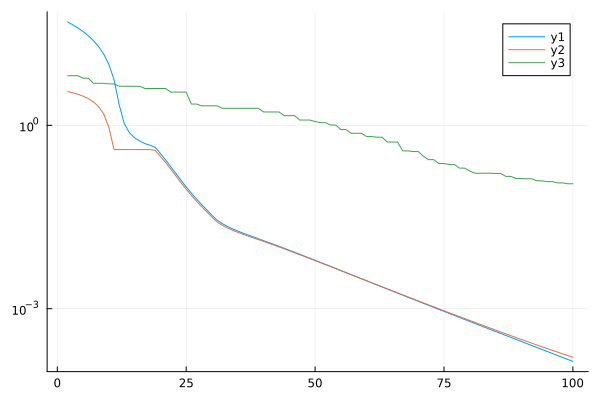

In [12]:
x = 1:maxiters;
y1 = fbest .- gbest; # duality gap
y2 = fbest .- f_min; # projected subgradient for dual
y3 = fpbest .- f_min; # projected subgradient for primal
plot(x, y1, yaxis=:log)
plot!(x, y2)
plot!(x, y3)

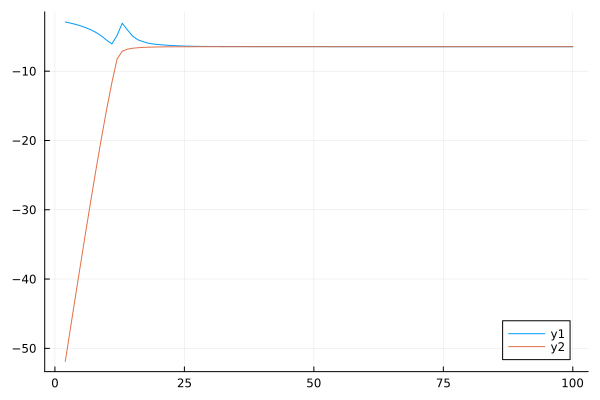

In [13]:
plot(x, f)
plot!(x, g)

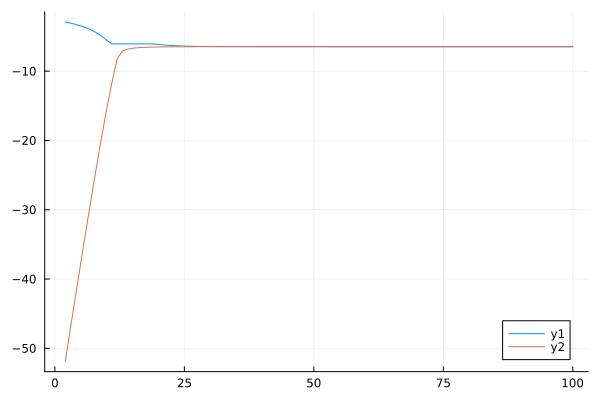

In [14]:
plot(x, fbest)
plot!(x, gbest)